# NLP Capstone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
sns.set_style('white')

# Examine the Data

In [2]:
# Let's use articles from the Reuters Corpus.
from nltk.corpus import reuters, stopwords

In [3]:
# We'll choose some categories at random and use those for the rest of our analysis.
np.random.seed(3)
categories = list(np.random.choice(reuters.categories(), 15, replace=False))
print(categories)

['tin', 'coffee', 'gold', 'yen', 'rubber', 'palm-oil', 'lin-oil', 'rape-oil', 'wheat', 'soy-oil', 'nickel', 'cocoa', 'sugar', 'nzdlr', 'sorghum']


In [4]:
# Check that our categories have relatively the same order of magnitude of articles associated with them.
[(len(reuters.fileids(x)), x) for x in categories]

[(30, 'tin'),
 (139, 'coffee'),
 (124, 'gold'),
 (59, 'yen'),
 (49, 'rubber'),
 (40, 'palm-oil'),
 (2, 'lin-oil'),
 (8, 'rape-oil'),
 (283, 'wheat'),
 (25, 'soy-oil'),
 (9, 'nickel'),
 (73, 'cocoa'),
 (162, 'sugar'),
 (4, 'nzdlr'),
 (34, 'sorghum')]

In [5]:
# See how many articles are attached to those categories, the filenames of a few, and total word count.
print('Number of articles:', len(reuters.fileids(categories)))
fileids = reuters.fileids(categories)
print(fileids[:5])
print('Number of total words:', len(reuters.words(fileids)))

Number of articles: 962
['test/14832', 'test/14833', 'test/14840', 'test/14841', 'test/14842']
Number of total words: 227749


Note that in the Reuters corpus, categories are overlapping and each article can be tagged with multiple categories. This may add some complexity to our analysis, but it's also more representative of a real-world NLP project where specific web pages may have multiple topics associated with them.

In [6]:
# We may also be pulling in a lot of other categories in this process because articles can have multiple associations.
# Let's see all the categories we're getting.
all_categories = reuters.categories(fileids)
category_counts = [[len(set(reuters.fileids(x)).intersection(fileids)), x] for x in all_categories]
sorted(category_counts, reverse=True)[:15]

[[311, 'grain'],
 [283, 'wheat'],
 [162, 'sugar'],
 [139, 'coffee'],
 [124, 'gold'],
 [104, 'corn'],
 [73, 'cocoa'],
 [68, 'oilseed'],
 [67, 'veg-oil'],
 [59, 'yen'],
 [56, 'money-fx'],
 [51, 'soybean'],
 [49, 'rubber'],
 [40, 'palm-oil'],
 [36, 'dlr']]

So, we've got a few common categories that we didn't choose explicitly, but which turned out to be popular across the articles that were selected. For instance, 'grain' wasn't in the initial list, but 'wheat' and 'sorghum' are both grains, so it is popular. 'Corn' and 'veg-oil' as well. This should be fine -- it means we may end up clustering by some of these more general categories during unsupervised learning.

In [7]:
# There are three ways we can look at each file: Full text, words, and categories.
# We'll use 'words' for BoW, full text for Tfidf, and categories for classification in both.
print('Raw:\n', reuters.raw('test/14832')[:250])
print('\nWords:\n', reuters.words('test/14832')[:50])
print('\n\nCategories:\n', reuters.categories('test/14832'))

Raw:
 THAI TRADE DEFICIT WIDENS IN FIRST QUARTER
  Thailand's trade deficit widened to 4.5
  billion baht in the first quarter of 1987 from 2.1 billion a
  year ago, the Business Economics Department said.
      It said Janunary/March imports rose to 65.1 

Words:
 ['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', 'QUARTER', 'Thailand', "'", 's', 'trade', 'deficit', 'widened', 'to', '4', '.', '5', 'billion', 'baht', 'in', 'the', 'first', 'quarter', 'of', '1987', 'from', '2', '.', '1', 'billion', 'a', 'year', 'ago', ',', 'the', 'Business', 'Economics', 'Department', 'said', '.', 'It', 'said', 'Janunary', '/', 'March', 'imports', 'rose', 'to', '65', '.']


Categories:
 ['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']


# Clean the Data

Because we're already given a method for accessing individual words, we'll have a bit less data cleaning to do.

In [8]:
# Create a list with each article as an element.
articles = [reuters.raw(x) for x in fileids]
print('Before:', articles[5][:200], '\n')

# Let's make them all lowercase and remove white space.
articles = [' '.join(x.split()).lower() for x in articles]
print('After:', articles[5][:200], '\n')

# And grabbing categories by article.
categories_by_article = [reuters.categories(x) for x in fileids]
print(categories_by_article[:5])

Before: SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTENSION
  Mines and Energy Minister Subroto
  confirmed Indonesian support for an extension of the sixth
  International Tin Agreement (ITA), but said a new  

After: subroto says indonesia supports tin pact extension mines and energy minister subroto confirmed indonesian support for an extension of the sixth international tin agreement (ita), but said a new pact w 

[['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade'], ['palm-oil', 'veg-oil'], ['coffee', 'lumber', 'palm-oil', 'rubber', 'veg-oil'], ['grain', 'wheat'], ['gold']]


That should be enough for the raw text, let's just touch up the 'Words' lists by making lowercase and removing punctuation, as we won't be using that for BoW. Instead of grabbing all the punctuation separately, I'll just get rid of all words length 2 or less and all stopwords. This will also deal with some common words and numbers and make our data a little easier to wrangle.

In [9]:
words_by_article = [reuters.words(x) for x in fileids]
print('Before:', words_by_article[5][:25])
print('Total Words:', sum([len(x) for x in words_by_article]), '\n')

# A set of stopwords will be faster to search through.
stopword_set = set(stopwords.words('english'))
for i, words in enumerate(words_by_article):
    words_by_article[i] = [x.lower() for x in words if (len(x) > 2) and not (x in stopword_set)]
print('After:', words_by_article[5][:25])
print('Total Words:', sum([len(x) for x in words_by_article]))

Before: ['SUBROTO', 'SAYS', 'INDONESIA', 'SUPPORTS', 'TIN', 'PACT', 'EXTENSION', 'Mines', 'and', 'Energy', 'Minister', 'Subroto', 'confirmed', 'Indonesian', 'support', 'for', 'an', 'extension', 'of', 'the', 'sixth', 'International', 'Tin', 'Agreement', '(']
Total Words: 227749 

After: ['subroto', 'says', 'indonesia', 'supports', 'tin', 'pact', 'extension', 'mines', 'energy', 'minister', 'subroto', 'confirmed', 'indonesian', 'support', 'extension', 'sixth', 'international', 'tin', 'agreement', 'ita', 'said', 'new', 'pact', 'necessary', 'asked']
Total Words: 119008


Nice, we've cut out nearly half the words from our data set that were unlikely to be useful. This should make things go faster and better from here on out.

# Bag of Words

Are we going to use lemmas, etc for this analysis? It's a bit slow and we've already got a nice clean set of words. Let's see how we do without getting into spaCy first, and add it if it seems useful.

## Setting Up BoW

In [10]:
from collections import Counter
import itertools

In [11]:
# Put all the strings into a single list.
allwords = [word for article in words_by_article for word in article]

# Count 'em up.
words_counted = Counter(allwords)

# Which words are most common?
print(words_counted.most_common(25))

[('said', 3481), ('the', 1749), ('tonnes', 1535), ('mln', 1331), ('000', 1176), ('wheat', 961), ('year', 814), ('sugar', 731), ('pct', 713), ('would', 682), ('coffee', 650), ('last', 616), ('1986', 578), ('export', 539), ('market', 539), ('dlrs', 537), ('prices', 527), ('gold', 518), ('new', 512), ('price', 442), ('trade', 425), ('may', 408), ('production', 391), ('cocoa', 376), ('producers', 363)]


Some of these words aren't great to have in our set. Let's remove some by hand, and then remove words that occur less than 3 times.

In [12]:
# Make a list of words to ignore, then cycle through the counter to remove them.
ignore = ['said', 'the', '000', 'year', 'pct', 'may']
for word in list(words_counted):
    if word in ignore:
        del words_counted[word]
print(words_counted.most_common(25))
print('Unique words:', len(list(words_counted)))

[('tonnes', 1535), ('mln', 1331), ('wheat', 961), ('sugar', 731), ('would', 682), ('coffee', 650), ('last', 616), ('1986', 578), ('export', 539), ('market', 539), ('dlrs', 537), ('prices', 527), ('gold', 518), ('new', 512), ('price', 442), ('trade', 425), ('production', 391), ('cocoa', 376), ('producers', 363), ('nil', 361), ('1987', 358), ('week', 351), ('one', 347), ('per', 347), ('stock', 346)]
Unique words: 9750


In [13]:
# We'll use itertools to delete all items that are not dropped by this lambda function.
for key, count in itertools.dropwhile(lambda key_count: key_count[1] >= 5, words_counted.most_common()):
    del words_counted[key]
print('Least common words:', words_counted.most_common()[::-1][:5])    
print('Unique words:', len(list(words_counted)))

Least common words: [('lechin', 5), ('arbitration', 5), ('awf', 5), ('martell', 5), ('citicorp', 5)]
Unique words: 3333


That's a bit better. Let's go ahead and make of DataFrame for modeling.

In [14]:
# Create a DataFrame, include article text, categories, and features for all the words in our list.
df_bow = pd.DataFrame(columns=['article_text', 'categories'] + list(words_counted))
df_bow['article_text'] = articles
df_bow['categories'] = categories_by_article
df_bow.fillna(0, inplace=True)
df_bow.head(3)

,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,indonesian commodity exchange may expand the i...,"[coffee, lumber, palm-oil, rubber, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And finally, we'll populate the word counts.

In [15]:
# Make a set of the feature names for faster searching.
features_set = set(words_counted)

# Iterate through the words in each article to add values to our DataFrame.
for i, article in enumerate(words_by_article):
    counter = Counter(article)
    for key, count in counter.most_common():
        if key in features_set:
            df_bow.loc[i, key] = count
            
df_bow.head(5)

,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",1,2,2,4,4,2,6,1,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,indonesian commodity exchange may expand the i...,"[coffee, lumber, palm-oil, rubber, veg-oil]",0,3,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,sri lanka gets usda approval for wheat price f...,"[grain, wheat]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,western mining to open new gold mine in austra...,[gold],0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Sanity check -- did we get everything counted?
print('"Trade" added up over the DataFrame:', df_bow['trade'].sum())
print('"Trade" from our original "words_counted" counter:', words_counted['trade'])

"Trade" added up over the DataFrame: 425
"Trade" from our original "words_counted" counter: 425


## Supervised BoW Model

In [17]:
print('df shape:', df_bow.shape)
df_bow.head(2)

df shape: (962, 3335)


,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",1,2,2,4,4,2,6,1,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


How will we treat the outcome variable, 'categories'? It's tricky having a number of categories associated with every article. Let's see if we can narrow it down to just the set of original categories.

In [18]:
# This is our list of original categories.
print(categories)
categories_set = set(categories)

['tin', 'coffee', 'gold', 'yen', 'rubber', 'palm-oil', 'lin-oil', 'rape-oil', 'wheat', 'soy-oil', 'nickel', 'cocoa', 'sugar', 'nzdlr', 'sorghum']


In [19]:
# Let's search through of 'categories' feature and see what matches up with those from the original group.
categories_reduced = [list(categories_set.intersection(df_bow['categories'][index])) for index in df_bow.index]
print(categories_reduced[:5])

# Create a new feature in our DF.
df_bow['categories_reduced'] = categories_reduced

[['tin', 'sugar', 'rubber'], ['palm-oil'], ['coffee', 'rubber', 'palm-oil'], ['wheat'], ['gold']]


Okay, we've gotten rid of all the extra categories, but many articles still have multiple associations. It turns out Random Forest, Decision Tree, KNN, and MLP already support multilabel output, although metrics won't work for it. 

http://scikit-learn.org/stable/modules/multiclass.html

Let's just run it on the reduced category set and see what happens. We do have to binarize our multilabel output.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

In [75]:
mlb = MultiLabelBinarizer()

# We have to exclude the category features we've been building.
X = df_bow.loc[:, ~df_bow.columns.isin(['article_text', 'categories', 'categories_reduced'])]
y = mlb.fit_transform(df_bow.categories_reduced)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
y_labels_train, y_labels_test = train_test_split(df_bow.categories_reduced, test_size=0.25, random_state=100)
print('Array shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Array shapes: (721, 3333) (241, 3333) (721, 15) (241, 15)


In [22]:
# Run Random Forest.
rfc = RandomForestClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Print out results for the test and predicted sets.
print('(Test set) (Model predictions)\n')
print(np.stack([mlb.inverse_transform(y_test), mlb.inverse_transform(y_pred)], axis=1)[:20])

(Test set) (Model predictions)

[[('wheat',) ('wheat',)]
 [('palm-oil',) ()]
 [('coffee',) ()]
 [('cocoa',) ()]
 [('wheat',) ('wheat',)]
 [('sugar',) ('sugar',)]
 [('sugar',) ()]
 [('cocoa',) ('cocoa',)]
 [('wheat',) ('wheat',)]
 [('sorghum',) ()]
 [('gold',) ('gold',)]
 [('rape-oil',) ()]
 [('sugar',) ()]
 [('wheat',) ('wheat',)]
 [('wheat',) ('wheat',)]
 [('wheat',) ('wheat',)]
 [('gold',) ('gold',)]
 [('sorghum',) ()]
 [('coffee',) ('coffee',)]
 [('sugar',) ('sugar',)]]


It looks like we're doing really well, but this isn't a very analytical way to rate our model. The biggest issue seems to be in not predicting any category in certain cases rather than mislabeling. We can use 'score', however, this will be 'subset accuracy', which means every label must be predicted correctly for the example to count.

In [25]:
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

Training set score: 0.959778085992
Test set score: 0.647302904564


We're overfitting the training set, but it's possible that 0.64 isn't so bad on the test set, since we're looking at subset accuracy. Let's see if we can do better with this or other models, and for now we'll just use 'score' to measure effectiveness.

In [39]:
# These are the models that support multilabel output.
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [65]:
mlp_params = {'hidden_layer_sizes':[(200,), (30, 30,), (60, 60,)]}
mlp_grid = GridSearchCV(MLPClassifier(), param_grid=mlp_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', mlp_grid.best_params_)
print('Training set average cv score w/best parameters:', mlp_grid.best_score_)
print('Test set score w/best parameters:', mlp_grid.score(X_test, y_test))

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

Best GridSearchCV params: {'hidden_layer_sizes': (200,)}
Training set average cv score w/best parameters: 0.773925104022
Test set score w/best parameters: 0.796680497925


In [56]:
rfc_params = {'max_depth':[10, 30, None],
              'n_estimators':[10, 30, 100]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', rfc_grid.best_params_)
print('Training set average cv score w/best parameters:', rfc_grid.best_score_)
print('Test set score w/best parameters:', rfc_grid.score(X_test, y_test))

Best GridSearchCV params: {'max_depth': None, 'n_estimators': 100}
Training set average cv score w/best parameters: 0.760055478502
Test set score w/best parameters: 0.780082987552


In [62]:
dtc_params = {'max_depth':[10, 30, None],
              'min_samples_split':[2, 4, 8]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', dtc_grid.best_params_)
print('Training set average cv score w/best parameters:', dtc_grid.best_score_)
print('Test set score w/best parameters:', dtc_grid.score(X_test, y_test))

Best GridSearchCV params: {'max_depth': 30, 'min_samples_split': 2}
Training set average cv score w/best parameters: 0.918169209431
Test set score w/best parameters: 0.904564315353


In [63]:
knc_params = {'n_neighbors':[2, 4, 8, 16]}
knc_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', knc_grid.best_params_)
print('Training set average cv score w/best parameters:', knc_grid.best_score_)
print('Test set score w/best parameters:', knc_grid.score(X_test, y_test))

Best GridSearchCV params: {'n_neighbors': 4}
Training set average cv score w/best parameters: 0.631067961165
Test set score w/best parameters: 0.655601659751


It looks like Decision Tree is doing the best -- even better than Random Forest. Interesting! 90% subset accuracy on the test set is quite remarkable. Let's try some unsupervised techniques.

## Unsupervised BoW Model

What if we try out some unsupervised models? The overlapping outcomes may cause some issues around the borders, but let's see what happens.

In [66]:
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AffinityPropagation
from sklearn.decomposition import TruncatedSVD, PCA

In [82]:
# Run KMeans and grab the labels for training and test sets.
n_clusters=10
km = KMeans(n_clusters=n_clusters).fit(X_train)
km_labels_train = km.labels_
km_labels_test = km.predict(X_test)

In [127]:
# Now let's see which categories are most common for each cluster.
def label_clusters(model_clusters, true_labels):
    clust_dict = {}
    # Set up each cluster in a dictionary
    for label in set(model_clusters):
        clust_dict[label]=[]
    # Cycle through each example and append all the words.
    for i in range(len(model_clusters)):
        clust_dict[list(model_clusters)[i]].append(list(true_labels)[i])
    # Make each cluster a list of strings rather than a list of lists
    for key in clust_dict.keys():
        clust_dict[key]=[x[0] for x in clust_dict[key]]
    return clust_dict

In [128]:
clust_dict = label_clusters(km_labels_train, y_labels_train)
print(clust_dict[1])

['yen', 'yen', 'yen', 'yen', 'yen', 'nzdlr', 'nzdlr', 'yen', 'yen', 'yen', 'gold', 'yen', 'yen', 'yen', 'yen', 'yen', 'yen', 'gold', 'yen', 'yen', 'yen']


It worked! Kind of. Now we need a way to look at the results. Let's see how many of the labels are the most common for each cluster, and how many are others.

In [124]:
test = clust_dict[1]
print(test)
set([x[0] for x in test])

[['yen'], ['yen'], ['yen'], ['yen'], ['yen'], ['nzdlr'], ['nzdlr'], ['yen'], ['yen'], ['yen'], ['gold'], ['yen'], ['yen'], ['yen'], ['yen'], ['yen'], ['yen'], ['gold'], ['yen'], ['yen'], ['yen']]


{'gold', 'nzdlr', 'yen'}

In [ ]:
def find_common(labels):
    

# Tfidf

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [130]:
# Create the model, fit, and transform the original articles. Each article is one row.

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=7,
                             stop_words='english',
                             lowercase=True,
                             ngram_range=(1,2),
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

articles_tfidf = vectorizer.fit_transform(articles)
print('Number of Articles and Features:', articles_tfidf.get_shape())

Number of Articles and Features: (962, 3065)


In [131]:
# Split original articles, file ids, and Tfidf results into train and test.
X_train, X_test = train_test_split(articles, test_size=0.25, random_state=50)
fileids_train, fileids_test = train_test_split(fileids, test_size=0.25, random_state=50)
X_tfidf_train, X_tfidf_test = train_test_split(articles_tfidf, test_size=0.25, random_state=50)

# Make a version we can read.
X_tfidf_train_csr = X_tfidf_train.tocsr()

# Number of training articles
n = X_tfidf_train.get_shape()[0]

# A list of dictionaries, one per paragraph
tfidf_byarticle = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_train_csr.nonzero()):
    tfidf_byarticle[i][terms[j]] = X_tfidf_train_csr[i, j]
    
print('Original Article:\n', X_train[5][:300], '...')
print('\n\nTfidf Vector:\n', tfidf_byarticle[5])
print('\n\nOriginal Categories:\n', reuters.categories(fileids_train[5]))

Original Article:
 talking point/gold the price of gold bullion and share prices of north american gold stocks are benefiting from continued weakness in the u.s. dollar, analysts said. "there's been a tug of war between the (currency) speculators and the central banks over the u.s. dollar and it looks like the game ha ...


Tfidf Vector:
 {'stock exchange': 0.068583855995053553, 'gained': 0.20575156798516064, 'lake': 0.064812098307609908, 'losing': 0.06594094959192659, 'funds': 0.05660248117540008, 'peak': 0.068583855995053553, 'break': 0.059656202422883192, 'talking': 0.067188836792021964, 'richard': 0.054176901492191426, 'implications': 0.067188836792021964, 'investors': 0.11430692605506962, 'points': 0.055571920695223022, 'uncertainty': 0.13188189918385318, 'gold silver': 0.058979219659812149, 'narrow': 0.063781537827432844, 'ratio': 0.061955781195155518, 'dlrs ounce': 0.12566702816984443, 'gold bullion': 0.067188836792021964, 'war': 0.13716771199010711, 'weakness': 0.06858385599505

In [132]:
# Build and fit our decomposition model. 
#We can alter the number of components until we're happy with our explained variance.
n_components = 100
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_tfidf_train)

print('Variance explained with {} components:'.format(n_components), svd.explained_variance_ratio_.sum())

Variance explained with 100 components: 0.515141872092


In [133]:
# Make a Dataframe with articles as indices and components as features
articles_by_component=pd.DataFrame(X_train_lsa,index=X_train)
articles_by_component.shape

# Show the highest values for a few components, along with their articles
for i in range(2):
    print('Component {}:'.format(i))
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:4])

Component 0:
ec driving to capture brazil wheat market - usda the european community, ec, sold 75,000 tonnes of soft wheat at a subsidized price of between 85 and 89 dlrs per tonne fob for march delivery in a continuing bid to establish itself in the brazilian wheat market, the u.s. agriculture department said. the sale sharply undercut the u.s. offer of 112 dlrs per tonne fob for 33,000 tonnes of wheat, it said in its latest report on export markets for u.s grains. ec sales to brazil total about 225,000 tonnes during 1986/87 (july-june) in stark contrast to only 50,000 tonnes in the 1985/86 season, it said. the increasing presence of ec wheat in brazil comes at a time when the brazilian wheat board, bwb, expects the wheat import market will expand to 3.4 mln tonnes from the current forecast of 3.0 mln in the 1986/87 year. the bwb cites record consumption and an eventual decline in domestic production, and says government plans to lower the guaranteed price of wheat from 242 dlrs per t

That's cool, but it would be easier to see how we're doing if we looked at the 'Category' labels provided rather than the full text.

In [134]:
# Make a list of the categories for each article
categories_train = [reuters.categories(x) for x in fileids_train]

# Make a Dataframe with categories as indices and components as features
categories_by_component=pd.DataFrame(X_train_lsa,index=[str(x) for x in categories_train])
categories_by_component.shape

# Show the highest values for a few components, along with their categories
for i in range(8):
    print('Component {}:'.format(i))
    print(categories_by_component.loc[:,i].sort_values(ascending=False)[0:8])

Component 0:
['grain', 'wheat']                                                                  0.679266
['grain', 'wheat']                                                                  0.644276
['sugar']                                                                           0.637431
['sugar']                                                                           0.618657
['grain', 'wheat']                                                                  0.610400
['corn', 'grain', 'wheat']                                                          0.595769
['corn', 'grain', 'oilseed', 'palm-oil', 'rapeseed', 'ship', 'soy-oil', 'wheat']    0.589662
['sugar']                                                                           0.572055
Name: 0, dtype: float64
Component 1:
['cocoa']     0.657370
['cocoa']     0.630749
['cocoa']     0.624951
['cocoa']     0.619634
['coffee']    0.612899
['cocoa']     0.607288
['cocoa']     0.604366
['coffee']    0.602723
Name: 1, dtype: float6

This is really cool. Note that we've used the raw text from the articles to sort into components, not the categories themselves -- we're just using the category labels provided to act as a check on how we're doing. Looks like we've got:
    - Component 0: grains/sugars (maybe some hidden dependency, like selling or buying?)
    - Component 1: cocoa/coffee
    - Component 2: gold and silver
    - Component 3: cocoa
    - Component 4: sugar
    - Component 5: wheat
    - Component 6: yen
    - Component 7: plant oils
    

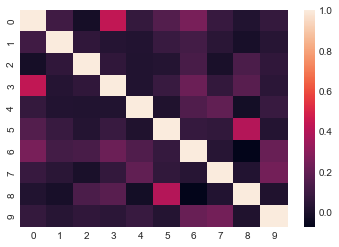

In [135]:
# Let's compute a similarity matrix and see which articles are most similar to each other.
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_mat = pd.DataFrame(similarity).iloc[0:10, 0:10]
sim_full = pd.DataFrame(similarity)
sns.heatmap(sim_mat, yticklabels=range(sim_mat.shape[1]))
plt.show()

In [136]:
# These two should be fairly similar.
print(X_train[0], X_train[3])

argentina-brazil trade jumped 90 pct in 1986 trade between argentina and brazil jumped 90 pct in 1986 versus 1985, foreign minister dante caputo said. speaking to reporters, caputo said the near doubling in trade showed the "tangible and immediate results" of a wide- ranging economic integration accord signed by the presidents of both countries last july. he said trade last year totalled 1.3 billion dlrs versus 700 mln dlrs in 1985. the accord provided for capital goods trade between the two countries to rise to 2.0 billion dlrs over four years. argentine wheat exports to brazil will increase from 1,375,000 tonnes in 1987 to 2.0 mln tonnes in 1991, the accord said. japan denies plans to cut duties on chocolate agriculture ministry officials said they are not considering cuts in import duties on chocolate to help ease friction with the united states over agricultural trade. japan has already lowered the duties sharply and we must consider domestic market conditions, an official said. du

It looks like the similarities are: they both have to do with trade, they both involve 1985 and 1986, and they both talk about billions of dollars. Let's see what some of the *most* similar pairs are in the matrix.

In [137]:
# Remove the 1's from the diagonal and find the remaining max index.
print((sim_full - np.identity(len(sim_full))).idxmax()[:10])

0    710
1    256
2    674
3    147
4    683
5    712
6    469
7    653
8    649
9    100
dtype: int64


In [138]:
print(sim_full.iloc[1, 256])
print(X_train[1], X_train[256])

0.752805950329
around 3.5 mln acres said to be idled by 0/92 a 0/92 program would have very little impact on u.s. acreage, prompting farmers to idle only an additional 3.5 mln acres of cropland every year, according to a report from the agriculture department. the savings resulting from the additional 3.5 mln acres idled would be a little over 400 mln dlrs in loan savings, 35 mln dlrs in transportation and storage savings, and 10-20 mln dlrs per year in deficiency payment savings, the report said. the usda report asssessed the impacts of the proposed 0/92 acreage program for wheat, corn, cotton, sorghum and barley. last year, almost 245 mln acres of those crops were harvested. "the likelihood that the 0-92 provisiion will cause very large acreages to be removed from crop production is quite small," the report said. "the returns on typical farms still favor participation in the usual acreage reduction programs and seeding the permitted acreage," the usda report said. the 0/92 program, w